In [1121]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.MNIST_model import MNIST_model
from src.MNIST_dataset import MNISTDataset
from src.train_config import Config as cfg

In [1122]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=(-0.1307 / 0.3081),
        std=(1 / 0.3081)
    )
])

train_dataset = MNISTDataset('/files/', train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

validation_dataset = MNISTDataset('/files/', train=False, transform=transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.batch_size, shuffle=True)

print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}")

Train: 60000, Validation: 10000


In [1123]:
val_sample = next(iter(validation_dataloader))
val_sample_data, val_sample_target = val_sample[0][0:1], val_sample[1][0].item()

In [1124]:
inverse_transform(val_sample_data[0]).shape

torch.Size([1, 28, 28])

In [1125]:
model = MNIST_model().to(cfg.device)
model.load_state_dict(torch.load(
    'results/model06_3_GAP_15epochs_6iters_lr005_batchsize256/best_model_state_model06_GAP_15epochs_6iters_lr005_batchsize256.h5' 
)) 
model = model.eval()
model

MNIST_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [1126]:
class Hook():
    def __init__(self,m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self,m,i,o):
        self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args):
        self.hook.remove()

In [1127]:
with Hook(model._modules.get('conv2')) as hook:
    with torch.no_grad():
        output = model.eval()(val_sample_data.to(cfg.device))
    act = hook.stored
print(act.shape)

torch.Size([1, 32, 28, 28])


In [1128]:
# pred = torch.sigmoid(output).cpu()
# print(pred)
# print(val_sample_target)
pred = F.softmax(output, dim=1).cpu()
print(pred)
print(val_sample_target)

tensor([[7.7141e-08, 4.3164e-08, 3.0192e-03, 9.9534e-01, 1.1797e-07, 3.3455e-05,
         7.7809e-12, 9.2542e-04, 2.9500e-05, 6.4920e-04]])
3


In [1129]:
target_pred = torch.argmax(pred).item()

In [1130]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data)
weight_softmax.shape

torch.Size([10, 32])

In [1131]:
for param in params:
    print(param.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [1132]:
# act[0].float()

In [1133]:
cam_map = torch.einsum('ck,kij->cij', weight_softmax, act[0])
cam_map.shape

torch.Size([10, 28, 28])

In [1134]:
normalized_cam_map = cam_map[val_sample_target]
min_val = torch.min(normalized_cam_map)
max_val = torch.max(normalized_cam_map)
range_val = max_val - min_val
normalized_cam_map = (normalized_cam_map - min_val) / range_val
normalized_cam_map = normalized_cam_map * (1.0 - 0.0) + 0.0
normalized_cam_map = normalized_cam_map.detach().cpu()

In [1135]:
torch.max(normalized_cam_map)

tensor(1.)

In [1136]:
cam_weights = weight_softmax[val_sample_target, :].cpu().numpy()
cam_weights

array([ 2.3708425e-01,  6.4788854e-01, -1.6691167e+00,  8.8863236e-01,
        1.2638532e+00,  5.5293053e-01,  7.5510728e-01,  4.4387102e-01,
        1.1712385e+00,  2.8251559e-01,  9.2191094e-01, -1.6296527e+00,
       -3.9683726e-01, -6.7424881e-01, -2.0615971e+00, -7.3227108e-01,
        1.3341761e+00,  1.1495314e+00, -2.8071783e+00,  4.7452427e-02,
        2.0910439e-01, -1.0199419e+00, -4.2561346e-01,  1.4041829e+00,
        1.3031851e+00, -9.0434694e-01, -1.3828391e-03, -7.4944890e-01,
        3.1609288e-01,  7.7729851e-01, -5.1839966e-01, -1.5539571e+00],
      dtype=float32)

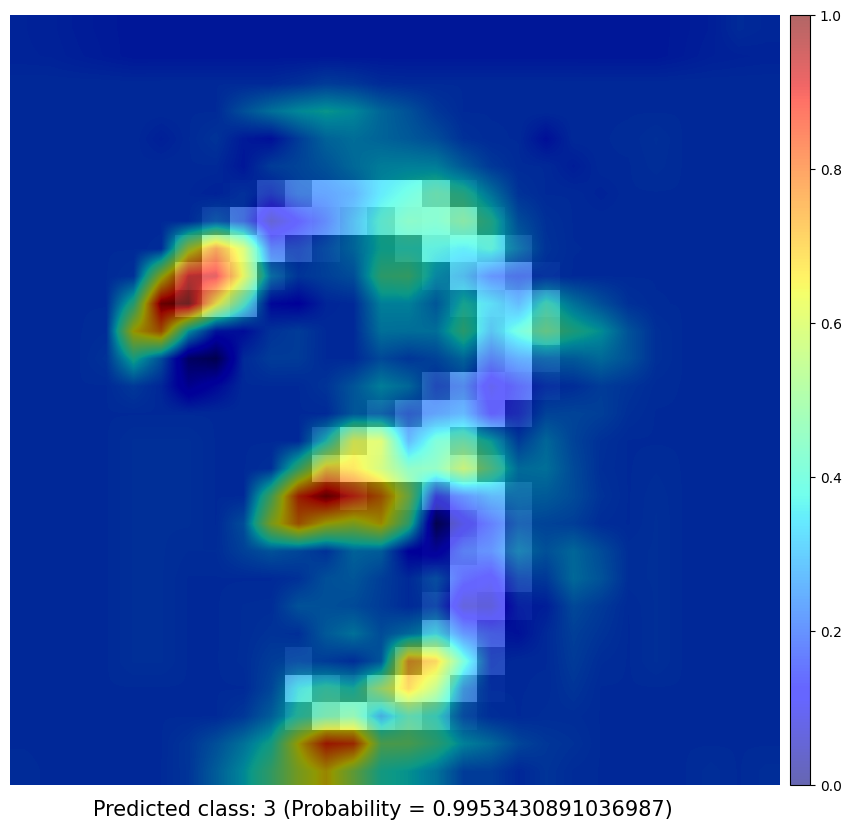

In [1137]:
from fastai.vision.all import *
x_dec = TensorImage(val_sample_data[0][0])
fig, ax = plt.subplots(figsize=(10,10))
x_dec.show(ctx=ax, cmap='gray')
plot = ax.imshow(normalized_cam_map, alpha=0.6
                #  , extent=(0,28,28,0)
                 , interpolation='bilinear', cmap='jet')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(plot, cax=cax)
plt.figtext(0.5, 0.08, "Predicted class: "+str(target_pred)+" (Probability = "+str(pred[0,target_pred].item())+")", ha="center", fontsize=15)
plt.show()

In [1138]:
torch.max(cam_map)

tensor(196.8444, device='cuda:0')

<Axes: >

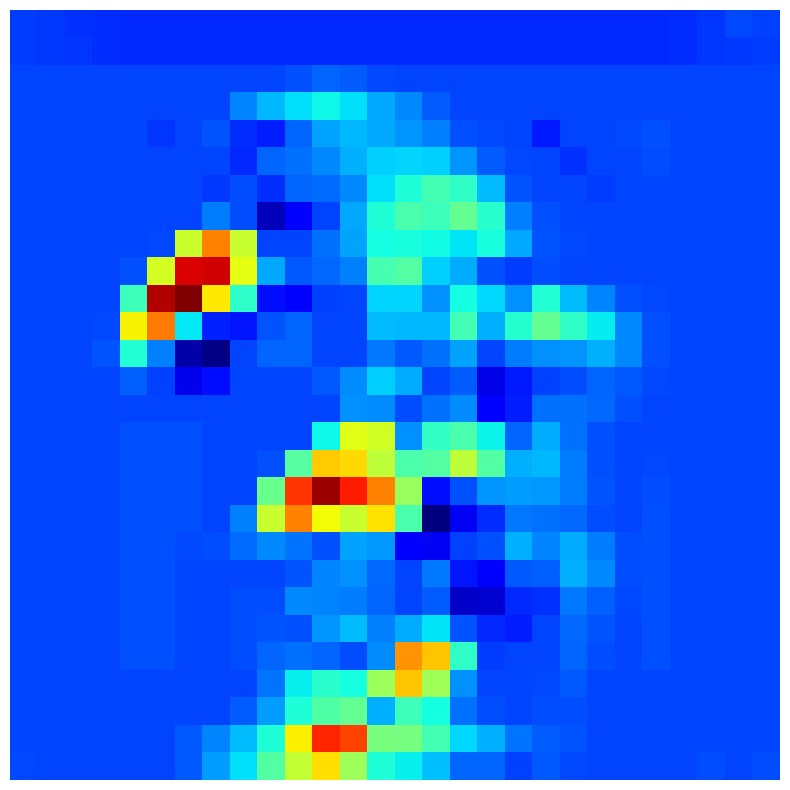

In [1139]:
cam_map_sample = TensorImage(cam_map[val_sample_target].detach().cpu())
_,ax = plt.subplots(figsize=(10,10))
cam_map_sample.show(ctx=ax, cmap='jet')

In [1140]:
cam_map[c].detach().cpu().shape

NameError: name 'c' is not defined

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(30,5))
for c in range(cfg.num_classes): 
    # x_dec.show(ctx=ax[c], cmap='gray')
    ax[c].imshow(cam_map[c].detach().cpu(), alpha=0.6
                    #  , extent=(0,28,28,0)
                    , interpolation='bilinear', cmap='jet')
    # cax = fig.add_axes([ax[c].get_position().x1+0.01,ax[c].get_position().y0,0.02,ax[c].get_position().height])
    # fig.colorbar(plot, cax=cax)
plt.show()